In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import crypten
from crypten import mpc
import crypten.communicator as comm


from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

from collections import defaultdict
import os

os.environ["CUDA_VISIBLE_DEVICES"]=""

In [12]:
df_nn = pd.read_csv("card_transdata.csv")

train_transactions, test_transactions = train_test_split(df_nn, test_size=0.2, random_state=42)


X_train_transactions = torch.from_numpy(train_transactions.drop(columns=["fraud"]).values)
y_train_transactions = torch.from_numpy(train_transactions.fraud.values).view(-1, 1)
X_test_transactions = torch.from_numpy(test_transactions.drop(columns=["fraud"]).values)
y_test_transactions = torch.from_numpy(test_transactions.fraud.values).view(-1, 1)

print(f"X_train_transactions has shape: {X_train_transactions.shape}")
print(f"y_train_transactions has shape: {y_train_transactions.shape}")
print(f"X_test_transactions has shape: {X_test_transactions.shape}")
print(f"y_test_transactions has shape: {y_test_transactions.shape}")




X_train_transactions has shape: torch.Size([800000, 7])
y_train_transactions has shape: torch.Size([800000, 1])
X_test_transactions has shape: torch.Size([200000, 7])
y_test_transactions has shape: torch.Size([200000, 1])


In [13]:
class CryptenFraudDetectionModel(crypten.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CryptenFraudDetectionModel, self).__init__()
        self.fc1 = crypten.nn.Linear(input_size, hidden_size)
        self.relu = crypten.nn.ReLU()
        self.dropout = crypten.nn.Dropout(0.5)
        self.fc2 = crypten.nn.Linear(hidden_size, num_classes)
        self.sigmoid = crypten.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

input_size = 7
hidden_size = 64
num_classes = 1
model = CryptenFraudDetectionModel(input_size, hidden_size, num_classes)

In [14]:
crypten.init()
torch.set_num_threads(1)

/home/vscode/.local/lib/python3.9/site-packages/crypten/__init__.py:64: RuntimeWarning: CrypTen is already initialized.
  warnings.warn("CrypTen is already initialized.", RuntimeWarning)


In [15]:
bank1 = 0
bank2 = 1
bank3 = 2
bank4 = 3

# Specify file locations to save data for each bank
filenames = {
    "X_samples_bank1": "data/X_samples_bank1.pth",
    "X_samples_bank2": "data/X_samples_bank2.pth",
    "X_samples_bank3": "data/X_samples_bank3.pth",
    "X_samples_bank4": "data/X_samples_bank4.pth",
    "y_samples_bank1": "data/y_samples_bank1.pth",
    "y_samples_bank2": "data/y_samples_bank2.pth",
    "y_samples_bank3": "data/y_samples_bank3.pth",
    "y_samples_bank4": "data/y_samples_bank4.pth",
}


label_eye = torch.eye(2)
y_train_transactions = y_test_transactions.long()
y_train_transactions = label_eye[y_train_transactions]

@mpc.run_multiprocess(world_size=4)
def save_all_data():   
    # Save split dataset for the 4 banks
    X_samples_bank1 = X_train_transactions[:2000]
    X_samples_bank2 = X_train_transactions[2000:4000]
    X_samples_bank3 = X_train_transactions[4000:6000]
    X_samples_bank4 = X_train_transactions[6000:8000]
    crypten.save_from_party(X_samples_bank1, filenames["X_samples_bank1"],src = bank1)
    crypten.save_from_party(X_samples_bank2, filenames["X_samples_bank2"],src = bank2)
    crypten.save_from_party(X_samples_bank3, filenames["X_samples_bank3"],src = bank3)
    crypten.save_from_party(X_samples_bank4, filenames["X_samples_bank4"],src = bank4)

    y_samples_bank1 = y_train_transactions[:2000]
    y_samples_bank2 = y_train_transactions[2000:4000]
    y_samples_bank3 = y_train_transactions[4000:6000]
    y_samples_bank4 = y_train_transactions[6000:8000]
    crypten.save_from_party(y_samples_bank1, filenames["y_samples_bank1"],src = bank1)
    crypten.save_from_party(y_samples_bank2, filenames["y_samples_bank2"],src = bank2)
    crypten.save_from_party(y_samples_bank3, filenames["y_samples_bank3"],src = bank3)
    crypten.save_from_party(y_samples_bank4, filenames["y_samples_bank4"],src = bank4)
    
    
save_all_data()


[None, None, None, None]

In [16]:
@mpc.run_multiprocess(world_size=4)
def encrypted_training():
    # Load data:
    x_bank1_enc = crypten.load_from_party(filenames['X_samples_bank1'], src=bank1)
    x_bank2_enc = crypten.load_from_party(filenames['X_samples_bank2'], src=bank2)
    x_bank3_enc = crypten.load_from_party(filenames['X_samples_bank3'], src=bank3)
    x_bank4_enc = crypten.load_from_party(filenames['X_samples_bank4'], src=bank4)

    y_bank1_enc = crypten.load_from_party(filenames['y_samples_bank1'], src=bank1)
    y_bank2_enc = crypten.load_from_party(filenames['y_samples_bank2'], src=bank2)
    y_bank3_enc = crypten.load_from_party(filenames['y_samples_bank3'], src=bank3)
    y_bank4_enc = crypten.load_from_party(filenames['y_samples_bank4'], src=bank4)
    model.encrypt()
    # Set train mode
    model.train()
    

    hist = defaultdict(list)
    # Combine the feature sets: identical to Tutorial 3
    x_combined_enc = crypten.cat([x_bank1_enc, x_bank2_enc, x_bank3_enc, x_bank4_enc], dim=0)
    y_combined_enc = crypten.cat([y_bank1_enc, y_bank2_enc, y_bank3_enc, y_bank4_enc], dim=0)
    crypten.print(x_combined_enc.size())
    crypten.print(y_combined_enc.size())

    loss = crypten.nn.loss.BCELoss()
    rank = comm.get().get_rank()

    # Define training parameters
    learning_rate = 0.0001
    num_epochs = 2
    batch_size = 100
    num_batches = x_combined_enc.size(0) // batch_size
    
    for i in range(num_epochs): 
        if rank == 0:
            crypten.print(f"Epoch {i} in progress:")       
        
        for batch in range(num_batches):
            # define the start and end of the training mini-batch
            start, end = batch * batch_size, (batch + 1) * batch_size
                                    
            # construct CrypTensors out of training examples / labels
            x_train = x_combined_enc[start:end]
            x_train.requires_grad = True
            y_train = y_combined_enc[start:end][:, :, 1]
            y_train.requires_grad = True
            # y_batch = labels_one_hot[start:end].squeeze(2)
            # y_train = crypten.cryptensor(y_batch, requires_grad=True).squeeze(2)

            # perform forward pass:
            output = model(x_train)
            # print("Output size: ", output.shape)
            # print("y_train size: ",y_train.shape)
            # print("output: ",output[0])
            # print("y_train: ",y_train[0])
            loss_value = loss(output, y_train)
            
            # set gradients to "zero" 
            model.zero_grad()

            # perform backward pass: 
            loss_value.backward()

            # update parameters
            model.update_parameters(learning_rate)
            
            # Print progress every batch:
            batch_loss = loss_value.get_plain_text()
            crypten.print(f"\tBatch {(batch + 1)} of {num_batches} Loss {batch_loss.item():.4f}")
            if batch % 10 == 0:
                f2_score = fbeta_score(np.where(output.get_plain_text() > 0.5, 1, 0), y_train.get_plain_text(), beta=0.5)
                crypten.print(f"\tBatch {(batch + 1)} of {num_batches} f2 score {f2_score:.4f}")
                hist["train_cost"].append({batch_loss.item():.4f})
                hist["train_f2"].append(f2_score)
    return hist

hist = encrypted_training()

torch.Size([8000, 7])
torch.Size([8000, 1, 2])
Epoch 0 in progress:
output: output: output: output:     MPCTensor(
	_tensor=tensor([8406988998482556373])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)MPCTensor(
	_tensor=tensor([-4632324332581278386])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)MPCTensor(
	_tensor=tensor([2962160498820531610])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)MPCTensor(
	_tensor=tensor([-6736825164721808599])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)



y_train: y_train:  y_train: y_train:  MPCTensor(
	_tensor=tensor([-7116201655433734439])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
) MPCTensor(
	_tensor=tensor([-6498508038147569489])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)
 
MPCTensor(
	_tensor=tensor([9002735579280373448])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)MPCTensor(
	_tensor=tensor([4611974114300930480])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)

	Batch 1 of 80 Loss 0.6627
	Batch 1 of 80 f2 score 0.2381
output: output: output: output:   

In [22]:
def plot_validation_curve(data, ax=None, ylim=None):
    if ax is None:
        fig, ax = plt.subplots()
        ax.set_title("Validation Curve")
        ax.set_ylabel("Cost")
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlabel("Epochs")
    ax.plot(data)


def plot_validation_curves(hist, ylim=None):
    fig, ax = plt.subplots(ncols=2, figsize=(16,5))

    ax[0].set_title("Train Cost")
    ax[0].set_ylabel("Cost")
    plot_validation_curve(hist['train_cost'], ax[0], ylim)

    ax[1].set_title("Train F2")
    ax[1].set_ylabel("F2")
    ax[1].set_ylim(-1, 1)
    plot_validation_curve(hist['train_f2'], ax[1])

    plt.tight_layout()

TypeError: list indices must be integers or slices, not str

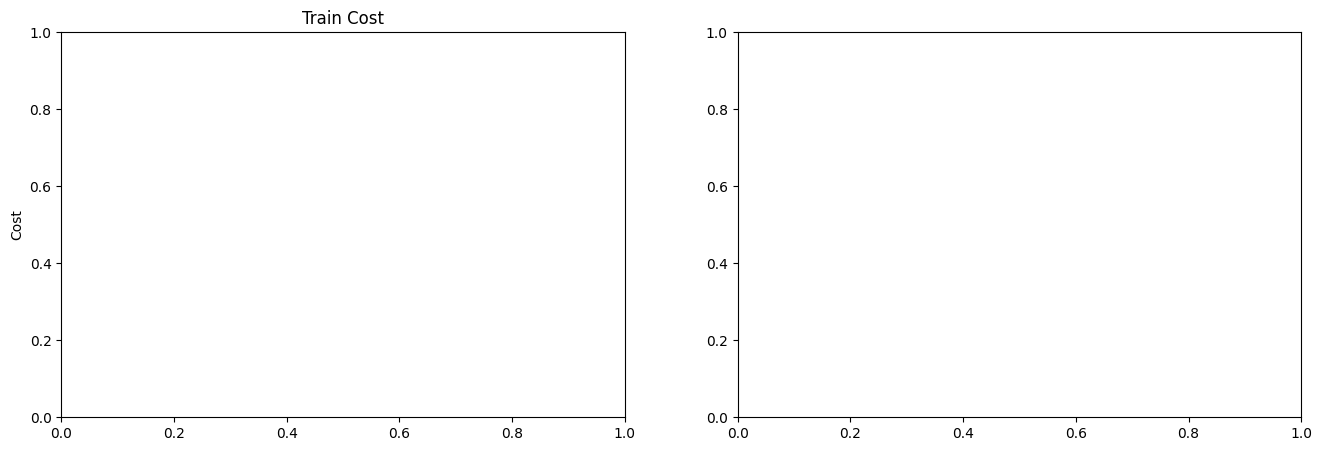

In [24]:
plot_validation_curves(hist)